In [1]:
from pathlib import Path
import datetime as dt
import re
from html import escape, unescape
import scipy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [30.0, 16.0] # Default: [6.0, 4.0]

In [2]:
def create_relative_time_column(df):

    df['Relative_time'] = dt.timedelta(seconds=0)  # Setting all the rows to 0, but only the first row will remain 0

    for i in range(1, len(df)):
        diff = df.index[i] - df.index[i-1]
        if diff.seconds > 600:
            diff = dt.timedelta(seconds=600)
        accumulated = df.Relative_time.iloc[i-1] + diff
        df.Relative_time.iat[i] = accumulated
    
    #df['Relative_time_seconds'] = df.Relative_time.apply(lambda x: x.seconds)
    
    df['Active_time'] = df.index[0] + df.Relative_time

In [3]:
def fill_nan_columns(df):
    # Filling NaNs
    df.update(df.filter(regex='^SourceEdit\d{1,}$').fillna(0))  # Filling NaNs with 0 wherever there is no SourceEdit event
    df.update(df.filter(regex='^JunitTest\d{1,}$').fillna(0))  # Filling NaNs with 0 wherever there is no JunitTest event
    df.update(df.filter(regex='^Launch\d{1,}$').fillna(0))  # Filling NaNs with 0 wherever there is no Launch event
    
    # Forward fill
    df.update(df.filter(regex='^SizeMeasure\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'SizeMeasure'
    df.update(df.filter(regex='^WarningCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'WarningCount'
    df.update(df.filter(regex='^Completion\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'Completion'
    df.update(df.filter(regex='^SuccessCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'SuccessCount'
    df.update(df.filter(regex='^FailureCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'FailureCount'
    df.update(df.filter(regex='^JunitTest_ErrorCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'JunitTest_ErrorCount'
    df.update(df.filter(regex='^SourceEdit_ErrorCount\d{1,}$').ffill().fillna(0))  # Forward-filling all columns beginning with 'JunitTest_ErrorCount'

In [4]:
def aggregate_columns(df):
    # Setting SourceEdit and JunitTest to 1 where any of the SourceEdit# or JunitTest# columns are 1
    df['SourceEdit'] = 0
    df.SourceEdit.iloc[np.where(df.filter(regex='^SourceEdit\d{1,}$') == 1)[0]] = 1
    df['JunitTest'] = 0
    df.JunitTest.iloc[np.where(df.filter(regex='^JunitTest\d{1,}$') == 1)[0]] = 1
    df['Launch'] = 0
    df.Launch.iloc[np.where(df.filter(regex='^Launch\d{1,}$') == 1)[0]] = 1
    
    df['TotalSizeMeasure'] = df.filter(regex='^SizeMeasure\d{1,}$').sum(axis=1)
    # We get the total completion by averaging all the Completion columns. Not skipping NaNs
    df['TotalCompletion'] = df.filter(regex='^Completion\d{1,}$').mean(skipna=False, axis=1)
    # Aggregating ErrorCount columns
    df['TotalJunitTest_ErrorCount'] = df.filter(regex='^JunitTest_ErrorCount\d{1,}$').sum(axis=1)
    df['TotalSourceEdit_ErrorCount'] = df.filter(regex='^SourceEdit_ErrorCount\d{1,}$').sum(axis=1)
    # Creating a total ErrorCount column
    df['TotalErrorCount'] = df.TotalJunitTest_ErrorCount + df.TotalSourceEdit_ErrorCount

In [5]:
def patch(original, edit, start, end):
    patched = original[:start] + edit + original[end + 1:]
    return patched

In [158]:
# 'data/csv/oving5/1395669706/Partner.csv'
#df = pd.read_csv('data/csv/oving5/0141126194/Partner.csv', index_col=0, parse_dates=True)
df = pd.read_csv('data/csv/oving5/0141126194/Card.csv', index_col=0, parse_dates=True)
# Merge duplicate indices (same exact timestamps)
df = df.groupby(level=0, sort=False).first()

In [159]:
df.isnull().sum()

SourceEdit1               39
SizeMeasure1              39
SourceEdit_ErrorCount1    39
WarningCount1             39
StoredString1             39
SourceEdit2               27
SizeMeasure2              27
SourceEdit_ErrorCount2    27
WarningCount2             27
StoredString2             29
JunitTest1                38
SuccessCount1             38
FailureCount1             38
JunitTest_ErrorCount1     38
Completion1               38
SourceEdit3               34
SizeMeasure3              34
SourceEdit_ErrorCount3    34
WarningCount3             34
StoredString3             34
Start2                    28
End2                      28
Start3                    35
End3                      35
JunitTest2                28
SuccessCount2             28
FailureCount2             28
JunitTest_ErrorCount2     28
Completion2               28
JunitTest3                33
SuccessCount3             33
FailureCount3             33
JunitTest_ErrorCount3     33
Completion3               33
Launch1       

In [160]:
df[['StoredString1', 'StoredString2', 'Start2', 'End2', 'StoredString3', 'Start3', 'End3']]

,StoredString1,StoredString2,Start2,End2,StoredString3,Start3,End3
2017-02-23 22:56:38,package objectstructures;\r\n\r\npublic class ...,package objectstructures;\r\n\r\nimport java.u...,NaN,NaN,NaN,NaN,NaN
2017-02-23 22:57:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-23 22:59:26,NaN,NaN,NaN,NaN,package objectstructures;\r\n\r\npublic class ...,NaN,NaN
2017-02-23 22:59:29,NaN,"public void deal(CardHand cardHand, int n) {\r...",1371.0,-348.0,NaN,NaN,NaN
2017-02-23 23:00:53,NaN,NaN,NaN,NaN,import java.util.ArrayList;\r\n\r\npublic clas...,27.0,-5.0
2017-02-23 23:02:30,NaN,NaN,NaN,NaN,\t\r\n\tpublic void addCard(Card card) {\r\n\t...,133.0,-5.0
2017-02-23 23:03:17,NaN,NaN,NaN,NaN,\t\r\n\tpublic void play(int n) {\r\n\t\thand....,190.0,-10.0
2017-02-23 23:13:12,NaN,for (int i = allCards.length - 1; i > allCards...,1418.0,-353.0,NaN,NaN,NaN
2017-02-23 23:13:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-23 23:13:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
df.StoredString2

2017-02-23 22:56:38    package objectstructures;\r\n\r\nimport java.u...
2017-02-23 22:57:24                                                  NaN
2017-02-23 22:59:26                                                  NaN
2017-02-23 22:59:29    public void deal(CardHand cardHand, int n) {\r...
2017-02-23 23:00:53                                                  NaN
2017-02-23 23:02:30                                                  NaN
2017-02-23 23:03:17                                                  NaN
2017-02-23 23:13:12    for (int i = allCards.length - 1; i > allCards...
2017-02-23 23:13:40                                                  NaN
2017-02-23 23:13:51                                                  NaN
2017-02-23 23:14:37                                                  NaN
2017-02-23 23:15:51                                                  NaN
2017-02-23 23:15:53                                                  NaN
2017-02-23 23:15:56                                

In [172]:
for column in df.filter(regex='^StoredString\d{1,}$').columns:
    print(column.upper())
    # Getting a Pandas Series object for the given column. Copy because we will alter it!
    stored_string_series = df[column].copy()
    # Removing all references to "\r" (carriage return). Hacky?
    stored_string_series = stored_string_series.str.replace('\r','')
    # Getting integer index of first valid index row
    first_valid = stored_string_series.index.get_loc(stored_string_series.first_valid_index())
    # Creating a deepcopy Series for the patched source code
    patched_series = stored_string_series.copy()
    # Setting everything except the first value to NaN
    patched_series.iloc[first_valid + 1:] = np.nan
    # Getting the start and end columns for the current stored string column:
    # FIXME: Hacky?
    # First, check if there is more than one storedString value. If not, we don't have any 'ReplaceSubstringEdit'
    # and thus no start or end columns
    file_number = ''.join(filter(str.isdigit, column))
    if stored_string_series.count() > 1:
        start_series = df['Start' + file_number]
        end_series = df['End' + file_number]
    else:
        print('This file has only been edited once, skipping.')
        df['SourceCode' + file_number] = patched_series.ffill()
        continue
    for row_idx in range(first_valid + 1, len(patched_series)):
        edit = stored_string_series.iloc[row_idx]
        if pd.isnull(edit):
            if not pd.isnull(start_series.iloc[row_idx]) and not pd.isnull(end_series.iloc[row_idx]):
                # We do have a start and end integer. Set edit to empty str since we are removing
                edit = ''
            else:
                # We just fill it with the latest patched value here to always have a value, and go to next iteration
                patched_series.iat[row_idx] = patched_series.iloc[row_idx - 1]
                continue
        print('SizeMeasure:', df['SizeMeasure' + file_number].iloc[row_idx])
        patched_series.iat[row_idx] = patch(patched_series.iloc[row_idx - 1], edit,
                                            int(start_series.iloc[row_idx]), int(end_series.iloc[row_idx]))
        print(patched_series.iloc[row_idx])
        
    # Naming convention for the patch column
    df['SourceCode' + file_number] = patched_series
    print('-'*20)

STOREDSTRING1
This file has only been edited once, skipping.
STOREDSTRING2
SizeMeasure: 77.0
package objectstructures;

import java.util.Arrays;

public class CardDeck {
	
	private Card[] spadeCards;
	private Card[] heartCards;
	private Card[] diamondCards;
	private Card[] clubCards;
	private Card[] allCards;
	
	public CardDeck(int n) {
		if (n < 1 || n > 13) {
			throw new IllegalAccessError("There are only 13 different faces of such a card game.");
		}
		spadeCards = new Card[n];
		heartCards = new Card[n];
		diamondCards = new Card[n];
		clubCards = new Card[n];
		allCards = new Card[4 * n];
		for (int i = 0; i < n; i++) {
			spadeCards[i] = new Card('S', i + 1);
			heartCards[i] = new Card('H', i + 1);
			diamondCards[i] = new Card('D', i + 1);
			clubCards[i] = new Card('C', i + 1);
			
			allCards[i] = spadeCards[i];
			allCards[i + n] = heartCards[i];
			allCards[i + 2 * n] = diamondCards[i];
			allCards[i + 3 * n] = clubCards[i];
		}
	}
	
	public int getCardCount() {
		return a

In [174]:
df.SourceCode3

2017-02-23 22:56:38                                                  NaN
2017-02-23 22:57:24                                                  NaN
2017-02-23 22:59:26    package objectstructures;\n\npublic class Card...
2017-02-23 22:59:29    package objectstructures;\n\npublic class Card...
2017-02-23 23:00:53    package objectstructures;\n\nimport java.util....
2017-02-23 23:02:30    package objectstructures;\n\nimport java.util....
2017-02-23 23:03:17    package objectstructures;\n\nimport java.util....
2017-02-23 23:13:12    package objectstructures;\n\nimport java.util....
2017-02-23 23:13:40    package objectstructures;\n\nimport java.util....
2017-02-23 23:13:51    package objectstructures;\n\nimport java.util....
2017-02-23 23:14:37    package objectstructures;\n\nimport java.util....
2017-02-23 23:15:51    package objectstructures;\n\nimport java.util....
2017-02-23 23:15:53    package objectstructures;\n\nimport java.util....
2017-02-23 23:15:56    package objectstructures;\n\

In [91]:
fill_nan_columns(df)

In [92]:
create_relative_time_column(df)

In [93]:
aggregate_columns(df)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [86]:
df

,SourceEdit1,SizeMeasure1,SourceEdit_ErrorCount1,WarningCount1,JunitTest1,SuccessCount1,FailureCount1,JunitTest_ErrorCount1,Completion1,Launch1,Relative_time,Active_time,SourceEdit,JunitTest,Launch,TotalSizeMeasure,TotalCompletion,TotalJunitTest_ErrorCount,TotalSourceEdit_ErrorCount,TotalErrorCount
2017-02-22 19:54:17,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00:00:00,2017-02-22 19:54:17,1.0,NaN,NaN,6.0,0.0,0.0,0.0,0.0
2017-02-22 19:54:23,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00:00:06,2017-02-22 19:54:23,1.0,NaN,NaN,7.0,0.0,0.0,0.0,0.0
2017-02-22 20:01:09,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00:06:52,2017-02-22 20:01:09,1.0,NaN,NaN,9.0,0.0,0.0,0.0,0.0
2017-02-22 20:01:21,1.0,9.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00:07:04,2017-02-22 20:01:21,1.0,NaN,NaN,9.0,0.0,0.0,4.0,4.0
2017-02-22 20:04:46,1.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00:10:29,2017-02-22 20:04:46,1.0,NaN,NaN,9.0,0.0,0.0,0.0,0.0
2017-02-22 20:04:56,1.0,11.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00:10:39,2017-02-22 20:04:56,1.0,NaN,NaN,11.0,0.0,0.0,2.0,2.0
2017-02-22 20:05:01,1.0,12.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00:10:44,2017-02-22 20:05:01,1.0,NaN,NaN,12.0,0.0,0.0,2.0,2.0
2017-02-22 20:05:03,1.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,00:10:46,2017-02-22 20:05:03,1.0,NaN,NaN,12.0,0.0,0.0,0.0,0.0
2017-02-22 20:05:55,1.0,13.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,00:11:38,2017-02-22 20:05:55,1.0,NaN,NaN,13.0,0.0,0.0,0.0,0.0
2017-02-22 20:05:57,1.0,15.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,00:11:40,2017-02-22 20:05:57,1.0,NaN,NaN,15.0,0.0,0.0,0.0,0.0


In [95]:
df['TotalRuns'] = df.JunitTest + df.Launch

In [140]:
df['TotalRuns_ma5'] = df.TotalRuns.rolling(10).mean()

In [141]:
df.TotalRuns_ma5

2017-02-22 19:54:17    NaN
2017-02-22 19:54:23    NaN
2017-02-22 20:01:09    NaN
2017-02-22 20:01:21    NaN
2017-02-22 20:04:46    NaN
2017-02-22 20:04:56    NaN
2017-02-22 20:05:01    NaN
2017-02-22 20:05:03    NaN
2017-02-22 20:05:55    NaN
2017-02-22 20:05:57    0.0
2017-02-22 20:05:57    0.0
2017-02-22 20:06:21    0.0
2017-02-22 20:06:38    0.0
2017-02-22 20:06:45    0.0
2017-02-22 20:06:53    0.0
2017-02-22 20:07:02    0.0
2017-02-22 20:07:07    0.0
2017-02-22 20:07:09    0.0
2017-02-22 20:07:47    0.0
2017-02-22 20:07:52    0.0
2017-02-22 20:08:14    0.0
2017-02-22 20:08:31    0.0
2017-02-22 20:08:42    0.0
2017-02-22 20:09:02    0.0
2017-02-22 20:09:13    0.0
2017-02-22 20:09:41    0.0
2017-02-22 20:09:52    0.0
2017-02-22 20:10:01    0.0
2017-02-22 20:10:04    0.0
2017-02-22 20:10:20    0.0
                      ... 
2017-02-22 22:20:32    0.3
2017-02-22 22:20:45    0.3
2017-02-22 22:21:06    0.3
2017-02-22 22:21:07    0.3
2017-02-22 22:21:14    0.4
2017-02-22 22:21:17    0.5
2

In [97]:
df['SizeMeasure1_change'] = df.SizeMeasure1.diff().abs()

In [98]:
df.SizeMeasure1_change

2017-02-22 19:54:17    NaN
2017-02-22 19:54:23    1.0
2017-02-22 20:01:09    2.0
2017-02-22 20:01:21    0.0
2017-02-22 20:04:46    0.0
2017-02-22 20:04:56    2.0
2017-02-22 20:05:01    1.0
2017-02-22 20:05:03    0.0
2017-02-22 20:05:55    1.0
2017-02-22 20:05:57    2.0
2017-02-22 20:05:57    1.0
2017-02-22 20:06:21    2.0
2017-02-22 20:06:38    2.0
2017-02-22 20:06:45    2.0
2017-02-22 20:06:53    0.0
2017-02-22 20:07:02    4.0
2017-02-22 20:07:07    0.0
2017-02-22 20:07:09    2.0
2017-02-22 20:07:47    0.0
2017-02-22 20:07:52    2.0
2017-02-22 20:08:14    0.0
2017-02-22 20:08:31    2.0
2017-02-22 20:08:42    3.0
2017-02-22 20:09:02    2.0
2017-02-22 20:09:13    2.0
2017-02-22 20:09:41    0.0
2017-02-22 20:09:52    1.0
2017-02-22 20:10:01    0.0
2017-02-22 20:10:04    0.0
2017-02-22 20:10:20    2.0
                      ... 
2017-02-22 22:20:32    0.0
2017-02-22 22:20:45    0.0
2017-02-22 22:21:06    2.0
2017-02-22 22:21:07    0.0
2017-02-22 22:21:14    0.0
2017-02-22 22:21:17    0.0
2

In [142]:
df['SizeMeasure1_change_ma5'] = df.SizeMeasure1_change.rolling(10).mean()

In [143]:
df.SizeMeasure1_change_ma5

2017-02-22 19:54:17    NaN
2017-02-22 19:54:23    NaN
2017-02-22 20:01:09    NaN
2017-02-22 20:01:21    NaN
2017-02-22 20:04:46    NaN
2017-02-22 20:04:56    NaN
2017-02-22 20:05:01    NaN
2017-02-22 20:05:03    NaN
2017-02-22 20:05:55    NaN
2017-02-22 20:05:57    NaN
2017-02-22 20:05:57    1.0
2017-02-22 20:06:21    1.1
2017-02-22 20:06:38    1.1
2017-02-22 20:06:45    1.3
2017-02-22 20:06:53    1.3
2017-02-22 20:07:02    1.5
2017-02-22 20:07:07    1.4
2017-02-22 20:07:09    1.6
2017-02-22 20:07:47    1.5
2017-02-22 20:07:52    1.5
2017-02-22 20:08:14    1.4
2017-02-22 20:08:31    1.4
2017-02-22 20:08:42    1.5
2017-02-22 20:09:02    1.5
2017-02-22 20:09:13    1.7
2017-02-22 20:09:41    1.3
2017-02-22 20:09:52    1.4
2017-02-22 20:10:01    1.2
2017-02-22 20:10:04    1.2
2017-02-22 20:10:20    1.2
                      ... 
2017-02-22 22:20:32    0.4
2017-02-22 22:20:45    0.4
2017-02-22 22:21:06    0.5
2017-02-22 22:21:07    0.4
2017-02-22 22:21:14    0.3
2017-02-22 22:21:17    0.2
2

In [144]:
df['hypotese'] =  df.SizeMeasure1_change_ma5 / df.TotalRuns_ma5

In [145]:
df.hypotese

2017-02-22 19:54:17         NaN
2017-02-22 19:54:23         NaN
2017-02-22 20:01:09         NaN
2017-02-22 20:01:21         NaN
2017-02-22 20:04:46         NaN
2017-02-22 20:04:56         NaN
2017-02-22 20:05:01         NaN
2017-02-22 20:05:03         NaN
2017-02-22 20:05:55         NaN
2017-02-22 20:05:57         NaN
2017-02-22 20:05:57         inf
2017-02-22 20:06:21         inf
2017-02-22 20:06:38         inf
2017-02-22 20:06:45         inf
2017-02-22 20:06:53         inf
2017-02-22 20:07:02         inf
2017-02-22 20:07:07         inf
2017-02-22 20:07:09         inf
2017-02-22 20:07:47         inf
2017-02-22 20:07:52         inf
2017-02-22 20:08:14         inf
2017-02-22 20:08:31         inf
2017-02-22 20:08:42         inf
2017-02-22 20:09:02         inf
2017-02-22 20:09:13         inf
2017-02-22 20:09:41         inf
2017-02-22 20:09:52         inf
2017-02-22 20:10:01         inf
2017-02-22 20:10:04         inf
2017-02-22 20:10:20         inf
                         ...   
2017-02-

In [146]:
df_slice = df.hypotese[:'2017-02-22 20:10:00']
df_slice

2017-02-22 19:54:17    NaN
2017-02-22 19:54:23    NaN
2017-02-22 20:01:09    NaN
2017-02-22 20:01:21    NaN
2017-02-22 20:04:46    NaN
2017-02-22 20:04:56    NaN
2017-02-22 20:05:01    NaN
2017-02-22 20:05:03    NaN
2017-02-22 20:05:55    NaN
2017-02-22 20:05:57    NaN
2017-02-22 20:05:57    inf
2017-02-22 20:06:21    inf
2017-02-22 20:06:38    inf
2017-02-22 20:06:45    inf
2017-02-22 20:06:53    inf
2017-02-22 20:07:02    inf
2017-02-22 20:07:07    inf
2017-02-22 20:07:09    inf
2017-02-22 20:07:47    inf
2017-02-22 20:07:52    inf
2017-02-22 20:08:14    inf
2017-02-22 20:08:31    inf
2017-02-22 20:08:42    inf
2017-02-22 20:09:02    inf
2017-02-22 20:09:13    inf
2017-02-22 20:09:41    inf
2017-02-22 20:09:52    inf
Name: hypotese, dtype: float64

In [114]:
df_slice.plot()

ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

In [147]:
df_slice2 = df.hypotese['2017-02-22 20:21:00':'2017-02-22 20:40:00']
df_slice2.replace(np.inf, 100)

2017-02-22 20:22:11      3.500000
2017-02-22 20:22:17      6.000000
2017-02-22 20:23:40      5.333333
2017-02-22 20:23:43      4.000000
2017-02-22 20:23:55      7.500000
2017-02-22 20:24:06      6.500000
2017-02-22 20:24:27     14.000000
2017-02-22 20:24:58     13.000000
2017-02-22 20:25:03     14.000000
2017-02-22 20:25:15    100.000000
2017-02-22 20:25:17     12.000000
2017-02-22 20:31:15      9.000000
2017-02-22 20:31:16      4.500000
2017-02-22 20:31:27      4.500000
2017-02-22 20:31:29      2.000000
2017-02-22 20:31:44      1.666667
2017-02-22 20:31:46      1.000000
2017-02-22 20:31:47      0.600000
2017-02-22 20:31:48      0.333333
2017-02-22 20:31:58      0.333333
2017-02-22 20:32:06      0.600000
2017-02-22 20:32:12      0.400000
2017-02-22 20:32:32      0.750000
2017-02-22 20:32:38      0.600000
2017-02-22 20:34:23      1.250000
2017-02-22 20:34:25      0.800000
2017-02-22 20:35:48      1.000000
2017-02-22 20:35:51      1.000000
2017-02-22 20:35:56      1.333333
2017-02-22 20:

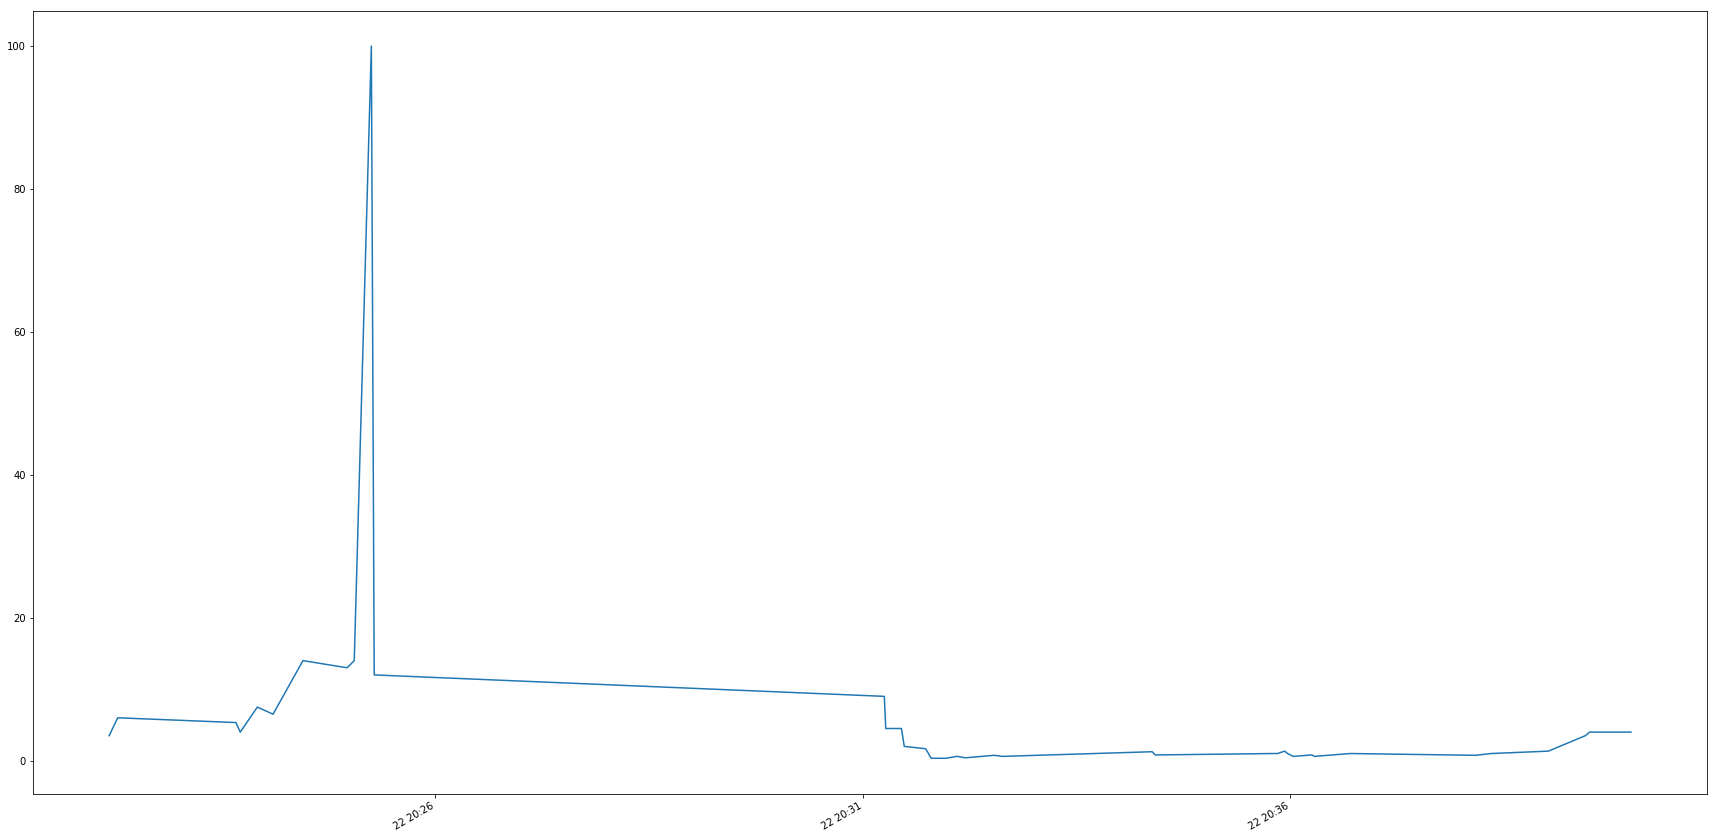

In [149]:
df_slice2.replace(np.inf, 100).plot()

In [128]:
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

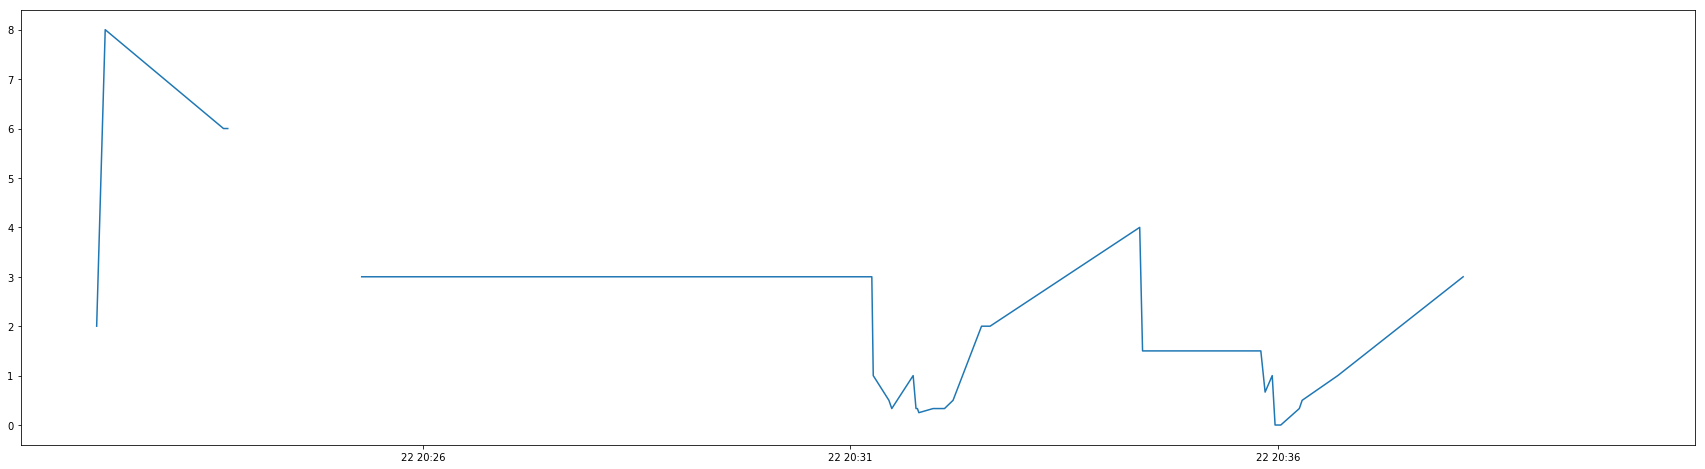

In [135]:
fig, ax = plt.subplots()
xtick_locator = AutoDateLocator(minticks=6)
xtick_formatter = AutoDateFormatter(xtick_locator, defaultfmt='%H:%M')
ax.xaxis.set_major_locator(xtick_locator)
ax.xaxis.set_major_formatter(xtick_formatter)
ax.plot(df_slice2)
plt.show()

## Possible features:

### Changes in size measure divived by how many times the code has been run
Using a moving average of 10 of both the difference in size measure and the total runs (Junit + Launch)

### Changes in size measure since last run.
Accumulate the size measure changes (diff) and reset every time we reach a run (either Junit or Launch)

### Time since last run in relative time (?)